In [42]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,FunctionTransformer
from sklearn.feature_selection import SelectKBest,f_regression,mutual_info_regression
from sklearn.model_selection import train_test_split, KFold,GridSearchCV
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression,Ridge,Lasso

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer,TransformedTargetRegressor

import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import mlflow

import featuretools as ft
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderServiceError

import warnings
warnings.filterwarnings("ignore")

In [43]:
mlflow.set_experiment('Boron Prediction')

<Experiment: artifact_location='file:///c:/Users/Willkommen%21/Desktop/Omdena/Code/IPAGE/notebooks/task_3_model_development_and_training/by-Jamsheeda/mlruns/862681235557549044', creation_time=1735173681758, experiment_id='862681235557549044', last_update_time=1735173681758, lifecycle_stage='active', name='Boron Prediction', tags={}>

In [44]:
df = pd.read_csv('./Data/merged_v2_geospatial_latest.csv')
df.tail()

,longitude,latitude,Area,Soil group,Land class,Soil type,pH,SOC,Nitrogen,Potassium,Phosphorus,Sulfur,Boron,Zinc,Sand,Silt,Clay,County,Country,State
2579,5.40560,9.96670,NaN,isda,isda,isda,6.10499,0.491113,0.031200,0.162866,3.39155,6.63695,0.009808,0.911567,66.0,19.0,14.0,NaN,NaN,Kebbi State
2580,6.06999,9.47827,NaN,isda,isda,isda,6.31601,0.405914,0.028539,0.143354,4.03134,5.75685,0.009814,0.882494,66.0,17.0,13.0,NaN,NaN,Kebbi State
2581,8.65110,8.36451,NaN,isda,isda,isda,5.86257,1.183850,0.062451,0.233885,2.53468,8.79315,0.009823,1.039760,70.0,20.0,15.0,NaN,NaN,Kebbi State
2582,11.39654,9.14604,NaN,isda,isda,isda,5.97490,0.335331,0.033715,0.124574,9.60043,5.34999,0.009902,0.858591,62.0,22.0,19.0,NaN,NaN,Kebbi State
2583,8.63908,8.38572,NaN,isda,isda,isda,6.22346,0.516436,0.021387,0.109438,4.22926,4.92892,0.009937,0.847897,70.0,18.0,14.0,NaN,NaN,Kebbi State


In [45]:
# grouping the states ['Katsina State','Kano State','Kwara State','Adamawa State']  as others because of their lower representation
df['State'] = df['State'].apply(lambda x:'Others' if x in ['Katsina','Kano','Kwara','Adamawa'] else x)
df['State'].value_counts()

State
Rangpur Division    477
Kebbi State         410
Niger State         387
Kaduna State        370
Plateau State       316
Bauchi State        193
Nasarawa State      170
Taraba State        113
Katsina State        72
Kano State           70
Kwara State           4
Adamawa State         2
Name: count, dtype: int64

In [46]:
numerical_features = ['pH', 'Nitrogen', 'Potassium', 'Phosphorus',
       'Sulfur', 'Sand', 'Silt', 'Clay']
categorical_features = ['State']
target = ['Boron']

In [47]:
X = df[numerical_features+categorical_features]
y = df[target]
print(X.shape,y.shape)

(2584, 9) (2584, 1)


#### Transformations to be applied to numerical and categorical columns

In [48]:
# function find the average of the numerical feature per category
def get_mean_per_category(X,categorical_features,numerical_features):
    X_transform = X.groupby(categorical_features)[numerical_features].transform(np.mean)
    X_transform.columns = [i+'_'+j+'_mean' for i in X[numerical_features].columns for j in categorical_features]
    X = pd.concat([X.drop(columns=categorical_features),X_transform],axis=1)
    return X


In [49]:
#X = get_mean_per_category(X,categorical_features,numerical_features)
#print(X.shape,y.shape)

In [50]:
def get_features_featuretools(X):
    # Numerical columns
    # Using featuretools library for numerical columns transformation
    print('inside featuretools')
    X['id'] = [i for i in range(X.shape[0])]
    y.reset_index(inplace=True,drop=True)

    dataframes = {
        "df_name": (X, "id"),
    }

    #trans_primitives = ['divide_by_feature','square_root','divide_numeric','natural_logarithm','multiply_numeric']
    trans_primitives = ['divide_numeric','multiply_numeric']
    feature_matrix,feature_dfs_train =ft.dfs(dataframes,
                                    target_dataframe_name='df_name', 
                                        trans_primitives=trans_primitives)
    
    print('shape of feature matrix of train with transformations:',feature_matrix.shape)

    #replacing NaNs or Infs with 0
    feature_matrix.replace([np.nan ,np.inf, -np.inf], 0, inplace=True)

    return feature_matrix
    

In [51]:
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scaler', MinMaxScaler()),
    #('featuretools',FunctionTransformer(get_features_featuretools))
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('encoder', OneHotEncoder)
])

In [52]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('mean_per_category',FunctionTransformer(get_mean_per_category,
                                             kw_args={'categorical_features':categorical_features,
                                                      'numerical_features':numerical_features}),
                                                      categorical_features+numerical_features),
    ]
)

In [53]:
# nested cross validation - outer loop for finding out the best model 
# and inner loop for finding out the best hyperparameters for each model

# configure the cross-validation procedure
cv_outer = KFold(n_splits=10, shuffle=True, random_state=1)
cv_outer_metrics = {'r2':list(),'mae':list(),'mse':list()}

models_list = {'xgb':XGBRegressor(enable_categorical=True),'lasso':Lasso(),'rf':RandomForestRegressor(),'lightgbm':LGBMRegressor()}
models_list = {'lasso':Lasso(),'rf':RandomForestRegressor ()}
params = {'lightgbm':
		  {
			'model__regressor__n_estimators':list(range(5,30,5)),
	 		'model__regressor__max_depth': list(range(1,10)),
			'model__regressor__subsample' : np.arange(0.5,1,0.1),
			'model__regressor__colsample_bytree' : np.arange(0.5,1,0.1)
		  },
		'xgb':
		  {'model__regressor__n_estimators':list(range(5,30,5)),
	 		'model__regressor__max_depth': list(range(1,10)),
			'model__regressor__subsample' : np.arange(0.5,1,0.1),
			'model__regressor__colsample_bytree' : np.arange(0.5,1,0.1)},
		  'rf':
		  {'model__regressor__n_estimators':list(range(15,50,5)),
	 		'model__regressor__max_depth': list(range(1,10)),
			'model__regressor__min_samples_split':list(range(2,12,2)),
			'model__regressor__max_features' : ['sqrt']},
		  'lasso':
		  {'model__regressor__alpha': np.arange(0.00, 1, 0.01)},
		  'ridge':
		  {'model__regressor__alpha': np.arange(0.00, 1, 0.01)}
		}
for model_name,model in models_list.items():
	with mlflow.start_run():
		print(model_name)
		mlflow.log_param('model',model_name)
		mlflow.log_param('info','used my geoprocessing info, grouped minority areas into others')
		for i,(train_ix, test_ix) in enumerate(cv_outer.split(X)):
			# split data
			#print(train_ix,test_ix)
			#print('Fold :',i)
			X_train, X_test = X.loc[train_ix, :], X.loc[test_ix, :]
			y_train, y_test = y.loc[train_ix], y.loc[test_ix]
			# configure the inner cross-validation procedure
			cv_inner = KFold(n_splits=3, shuffle=True, random_state=1)
			search_space = params[model_name]
			#define pipeline
			pipeline = Pipeline(steps=[('preprocessor',preprocessor),
								('model',TransformedTargetRegressor(regressor=model,
									transformer=MinMaxScaler()))])
			#pipeline = Pipeline(steps=[('model',model)])
			# define search
			grid_search = GridSearchCV(estimator = pipeline, 
								param_grid=search_space, 
								scoring='neg_mean_absolute_error', 
								cv=cv_inner, 
								refit=True,
								return_train_score=True)
			# execute search
			result = grid_search.fit(X_train, y_train)
			# get the best performing model fit on the whole training set
			best_model = result.best_estimator_
			# evaluate model on the hold out dataset
			y_pred = best_model.predict(X_test)
			# evaluate the model
			r2 = r2_score(y_test, y_pred)
			mae = mean_absolute_error(y_test,y_pred)
			mse = mean_squared_error(y_test,y_pred)
			# store the result
			cv_outer_metrics['r2'].append(r2)
			cv_outer_metrics['mae'].append(mae)
			cv_outer_metrics['mse'].append(mse)
			# report progress
			print(f'fold {i} : r2 on test data={r2}, mae on test_data ={mae}, best neg mae on cv inner={result.best_score_}, configuration={result.best_params_}')
		print(f'R2 mean:{np.mean(cv_outer_metrics["r2"])},mae mean:{np.mean(cv_outer_metrics["mae"])},mse mean:{np.mean(cv_outer_metrics["mse"])},R2 std:{np.std(cv_outer_metrics["r2"])}')
		#mlflow.log_model('model',best_model)
		mlflow.log_metrics({'R2':np.mean(cv_outer_metrics["r2"]),'MAE':np.mean(cv_outer_metrics["mae"]),'MSE':np.mean(cv_outer_metrics["mse"])})

lasso
fold 0 : r2 on test data=0.7759351046756144, mae on test_data =0.038921157939122285, best neg mae on cv inner=-0.04735785242126872, configuration={'model__regressor__alpha': np.float64(0.0)}
fold 1 : r2 on test data=0.6749861781782807, mae on test_data =0.044733172226132364, best neg mae on cv inner=nan, configuration={'model__regressor__alpha': np.float64(0.0)}
fold 2 : r2 on test data=0.6886519285935118, mae on test_data =0.04630594615689265, best neg mae on cv inner=nan, configuration={'model__regressor__alpha': np.float64(0.0)}
fold 3 : r2 on test data=0.6417934061212605, mae on test_data =0.04639202607137905, best neg mae on cv inner=nan, configuration={'model__regressor__alpha': np.float64(0.0)}
fold 4 : r2 on test data=0.719301347855255, mae on test_data =0.04666173021266482, best neg mae on cv inner=nan, configuration={'model__regressor__alpha': np.float64(0.0)}
fold 5 : r2 on test data=0.6106593808062893, mae on test_data =0.049532215470870215, best neg mae on cv inner=n

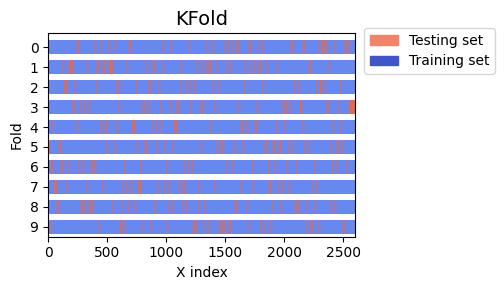

In [56]:
# Visualising kfold split
from matplotlib.patches import Patch

def plot_kfold(cv, X, y, ax, n_splits, xlim_max):
    """
    Plots the indices for a cross-validation object.

    Parameters:
    cv: Cross-validation object
    X: Feature set
    y: Target variable
    ax: Matplotlib axis object
    n_splits: Number of folds in the cross-validation
    xlim_max: Maximum limit for the x-axis
    """
    
    # Set color map for the plot
    cmap_cv = plt.cm.coolwarm
    cv_split = cv.split(X=X, y=y)
    
    for i_split, (train_idx, test_idx) in enumerate(cv_split):
        # Create an array of NaNs and fill in training/testing indices
        indices = np.full(len(X), np.nan)
        indices[test_idx], indices[train_idx] = 1, 0
        
        # Plot the training and testing indices
        ax_x = range(len(indices))
        ax_y = [i_split + 0.5] * len(indices)
        ax.scatter(ax_x, ax_y, c=indices, marker="_", 
                   lw=10, cmap=cmap_cv, vmin=-0.2, vmax=1.2)

    # Set y-ticks and labels
    y_ticks = np.arange(n_splits) + 0.5
    ax.set(yticks=y_ticks, yticklabels=range(n_splits),
           xlabel="X index", ylabel="Fold",
           ylim=[n_splits, -0.2], xlim=[0, xlim_max])

    # Set plot title and create legend
    ax.set_title("KFold", fontsize=14)
    legend_patches = [Patch(color=cmap_cv(0.8), label="Testing set"),
                      Patch(color=cmap_cv(0.02), label="Training set")]
    ax.legend(handles=legend_patches, loc=(1.03, 0.8))

# Create figure and axis
fig, ax = plt.subplots(figsize=(6, 3))
plot_kfold(cv_outer, X, y, ax, 10,xlim_max=2600)
plt.tight_layout()
fig.subplots_adjust(right=0.6)